In [100]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage.filters import median_filter, convolve
from scipy.ndimage import generic_filter
from skimage.morphology import opening, closing, erosion, dilation, skeletonize
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, estimate_sigma
from skimage.filters import threshold_local, gaussian
from skimage import measure 
from skimage.draw import circle_perimeter
import cv2

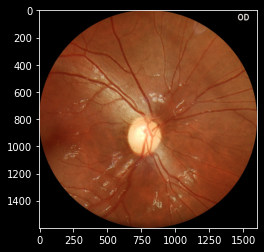

In [144]:
img = imageio.imread('images/4.jpg')
plt.imshow(img)

(1600, 1600)


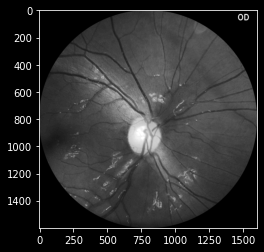

In [145]:
img_g = img[:,:,1]
print(img_g.shape)
plt.imshow(img_g,cmap='gray')

In [6]:
def filter_img(img, kernel_size=3, filter_type="mean"):
    if filter_type == "mean":
        weights = np.full((kernel_size, kernel_size), 1.0/(kernel_size**2))
        return convolve(img, weights=weights, mode="constant", cval=0)
    elif filter_type == "median":
        return median_filter(img, size=kernel_size)
    elif filter_type == "gaussian":
        kernel = np.zeros((kernel_size, kernel_size))
        kernel[kernel_size//2, kernel_size//2] = 1
        kernel = gaussian(kernel, sigma=1, mode='reflect')
        return convolve(img, weights=kernel, mode="constant", cval=0)
    else:
        print('Error! Filter should be either mean, median or gaussian!')
        return None

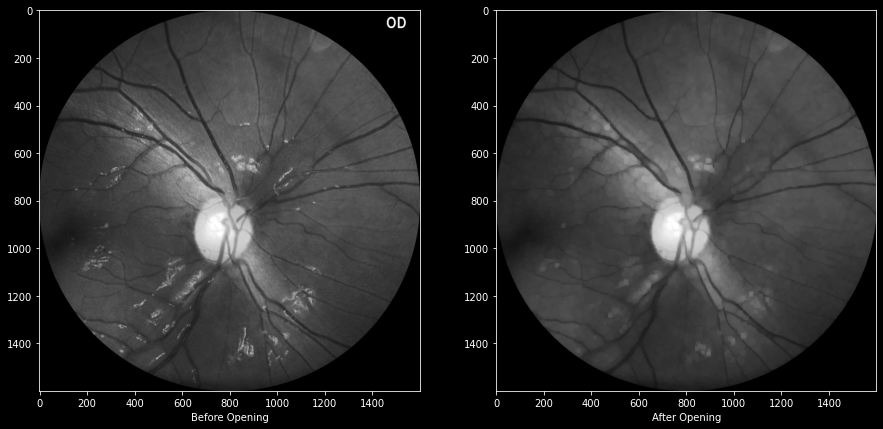

In [146]:
ker = np.ones((13, 13))
img_opening = opening(img_g, ker)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.xlabel('Before Opening')
plt.imshow(img_g, cmap="gray")
plt.subplot(122)
plt.xlabel('After Opening')
plt.imshow(img_opening, cmap="gray")


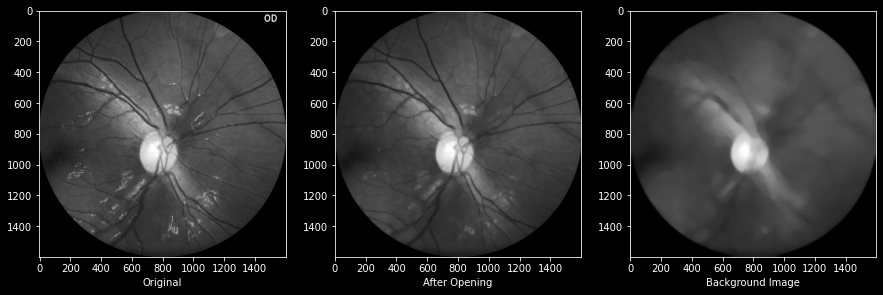

In [147]:
background = filter_img(img_opening, kernel_size=13, filter_type="mean")
background = filter_img(background, kernel_size=15, filter_type="gaussian")
background = filter_img(background, kernel_size=60, filter_type="median")

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.xlabel("Original")
plt.imshow(img_g, cmap="gray")
plt.subplot(132)
plt.xlabel("After Opening")
plt.imshow(img_opening, cmap="gray")
plt.subplot(133)
plt.xlabel("Background Image")
plt.imshow(background, cmap="gray")

In [148]:
imageio.imwrite('images/4_background_13_15_60.jpg', background)

In [149]:
def histogram(A, no_levels):
    # gets the size of the input matrix
    N, M = A.shape
    # creates an empty histogram with size proportional to the number of graylevels 
    hist = np.zeros(no_levels).astype(int)

    # computes for all levels in the range
    for i in range(no_levels):
        # sum all positions in which A == i is true
        pixels_value_i = np.sum(A == i)
        # store it in the histogram array
        hist[i] = pixels_value_i
            
    return(hist)

def histogram_equalization(A, no_levels):
    # computes the image histogram
    hist = histogram(A,  no_levels)
    
    # creates an empty cumulative histogram
    histC = np.zeros(no_levels).astype(int)

    # computes the cumulative histogram
    histC[0] = hist[0] # first value (intensity 0)
    # from intensity 1 to no_levels-1
    for i in range(1,  no_levels):
        histC[i] = hist[i] + histC[i-1]

    # the vector below is used to store the actual transformation function
    # it allows us to later visualize what was the function that computed
    # the equalisation
    hist_transform = np.zeros(no_levels).astype(np.uint8)
    
    # gets the size of the input image
    N, M = A.shape
    
    # create the image to store the equalised version
    A_eq = np.zeros([N,M]).astype(np.uint8)
    
    # for each intensity value, transforms it into a new intensity
    # using the np.where() function 
    for z in range(no_levels):
        # computes what would be the output level 's' for an input value 'z'
        s = ((no_levels-1)/float(M*N))*histC[z]
        
        # for every coordinate in which matrix A has the value 'z'
        # assigns the transformed/equalised value 's'
        A_eq[ np.where(A == z) ] = s
        
        # store the tranformation function
        hist_transform[z] = s
    
    return (A_eq, hist_transform)

Text(0.5, 0, 'Equalized histogram')

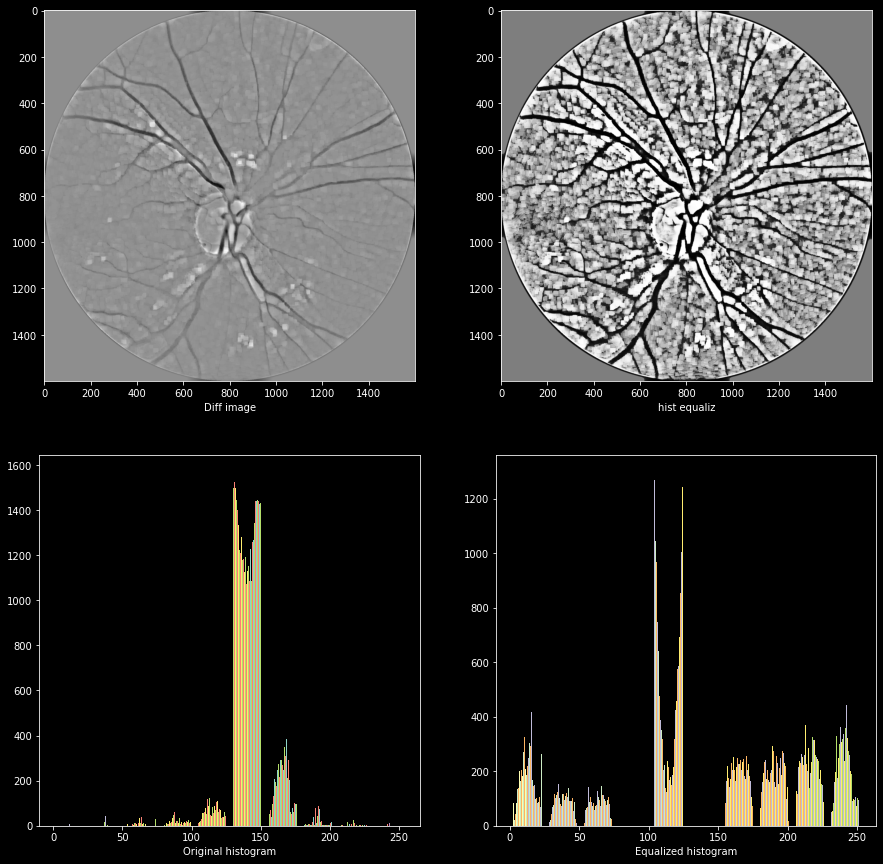

In [150]:
diff_img = img_opening.astype(np.int64) - background.astype(np.int64)
diff_img = ((diff_img - np.min(diff_img)) / (np.max(diff_img) - np.min(diff_img))*255).astype(np.uint8)
diff_img_eq, _ = histogram_equalization(diff_img, 256)

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.xlabel("Diff image")
plt.imshow(diff_img, cmap="gray")

plt.subplot(222)
plt.xlabel("hist equaliz")
plt.imshow(diff_img_eq, cmap="gray")

plt.subplot(223)
plt.xlabel('Original histogram')
plt.hist(diff_img)

plt.subplot(224)
plt.hist(diff_img_eq)
plt.xlabel('Equalized histogram')

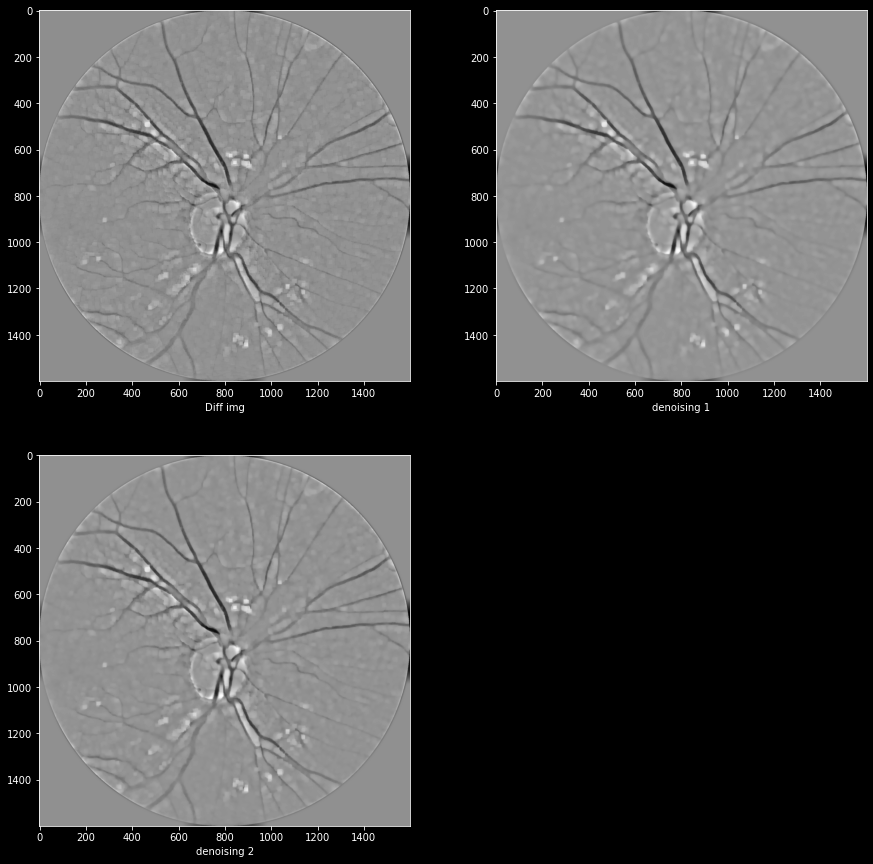

In [151]:

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.xlabel("Diff img")
plt.imshow(diff_img, cmap="gray")


denoised_1 = denoise_tv_chambolle(diff_img, weight=0.15)
plt.subplot(222)
plt.xlabel("denoising 1")
plt.imshow(denoised_1, cmap="gray")

denoised_2 = denoise_tv_chambolle(diff_img, weight=0.05)
plt.subplot(223)
plt.xlabel("denoising 2")
plt.imshow(denoised_2, cmap="gray")

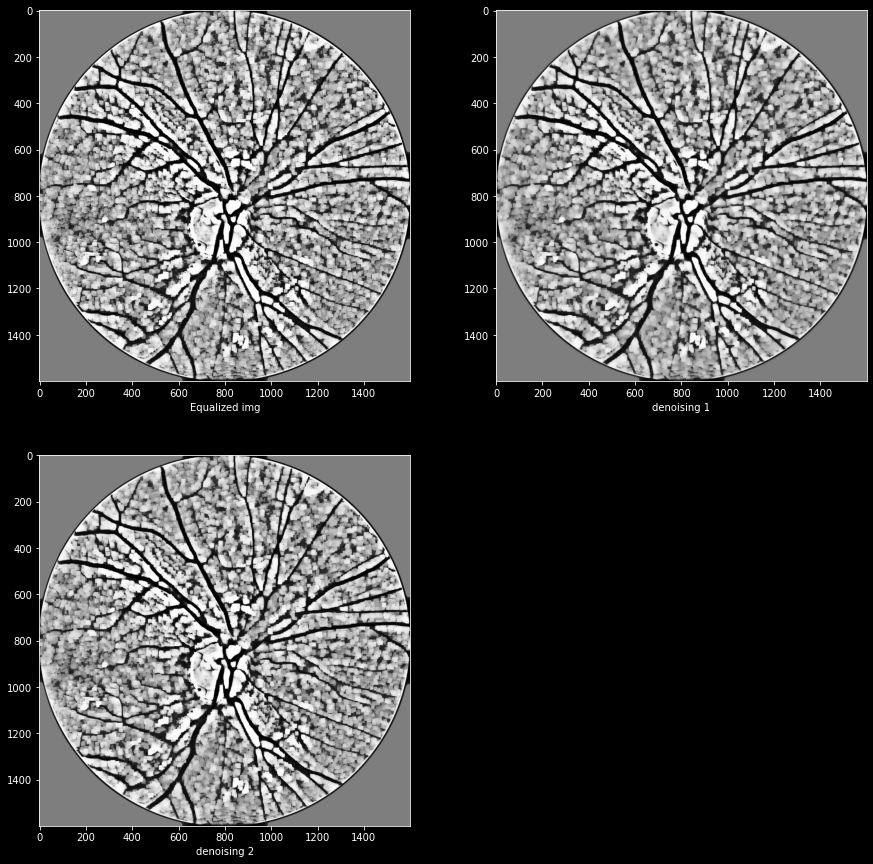

In [152]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.xlabel("Equalized img")
plt.imshow(diff_img_eq, cmap="gray")

# try to clean bg (gaussian maybe, to remove noise)
denoised_eq_1 = denoise_tv_chambolle(diff_img_eq, weight=0.15)
plt.subplot(222)
plt.xlabel("denoising 1")
plt.imshow(denoised_eq_1, cmap="gray")

denoised_eq_2 = denoise_tv_chambolle(diff_img_eq, weight=0.05)
plt.subplot(223)
plt.xlabel("denoising 2")
plt.imshow(denoised_eq_2, cmap="gray")

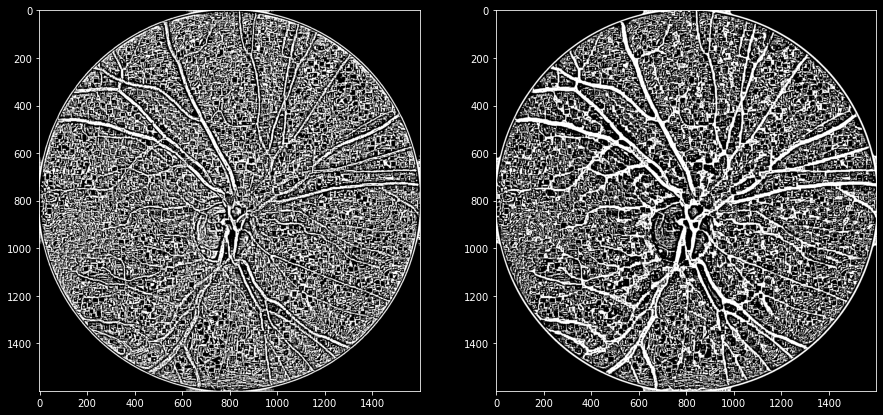

In [153]:
plt.figure(figsize=(15,15))

block_size = 15
parameter = 3
thresh_diff = threshold_local(diff_img, block_size=block_size, method='gaussian', param=parameter)
thresh_diff_img = diff_img < thresh_diff

thresh_eq = threshold_local(diff_img_eq, block_size=block_size, method='gaussian', param=parameter)
thresh_eq_img = diff_img_eq < thresh_eq


plt.subplot(121)
plt.imshow(thresh_diff_img, cmap='gray')

plt.subplot(122)
plt.imshow(thresh_eq_img, cmap='gray')


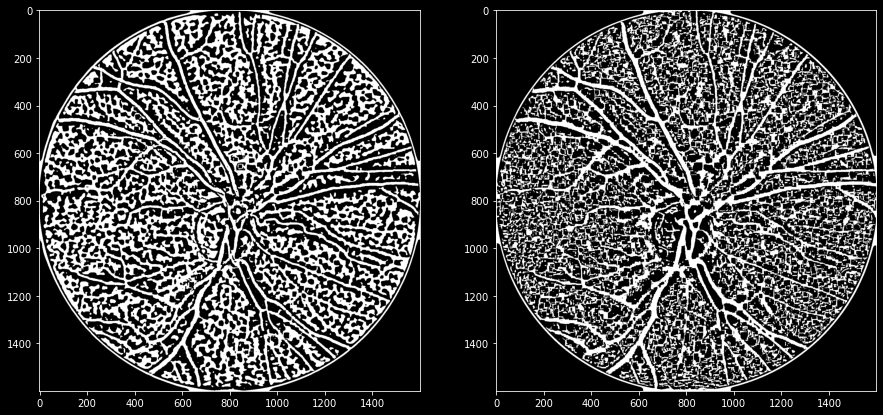

In [154]:
thresh_denoise_1 = threshold_local(denoised_1, block_size=block_size, method='gaussian', param=parameter)
thresh_img_denoise_1 = denoised_1 < thresh_denoise_1

thresh_denoise_eq_1 = threshold_local(denoised_eq_1, block_size=block_size, method='gaussian', param=parameter)
thresh_img_denoise_eq_1 = denoised_eq_1 < thresh_denoise_eq_1

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(thresh_img_denoise_1, cmap='gray')

plt.subplot(122)
plt.imshow(thresh_img_denoise_eq_1, cmap='gray')

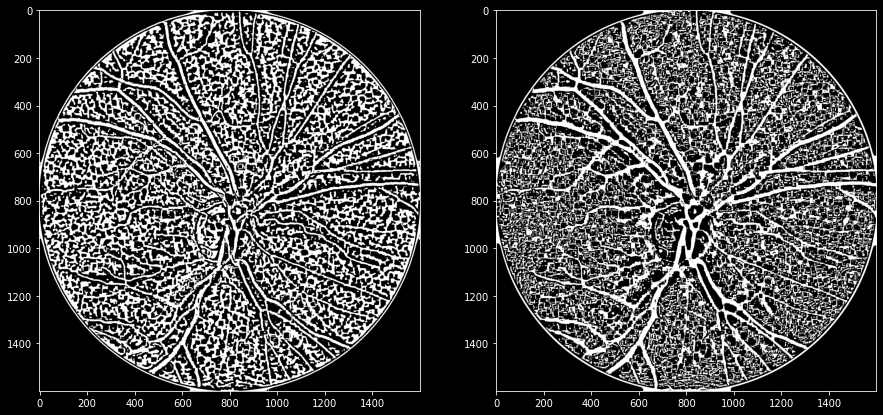

In [155]:
plt.figure(figsize=(15,15))

thresh_denoise_2 = threshold_local(denoised_2, block_size=block_size, method='gaussian', param=parameter)
thresh_img_denoise_2 = denoised_2 < thresh_denoise_2

thresh_denoise_eq_2 = threshold_local(denoised_eq_2, block_size=block_size, method='gaussian', param=parameter)
thresh_img_denoise_eq_2 = denoised_eq_2 < thresh_denoise_eq_2

plt.subplot(121)
plt.imshow(thresh_img_denoise_2, cmap='gray')
plt.subplot(122)
plt.imshow(thresh_img_denoise_eq_2, cmap='gray')

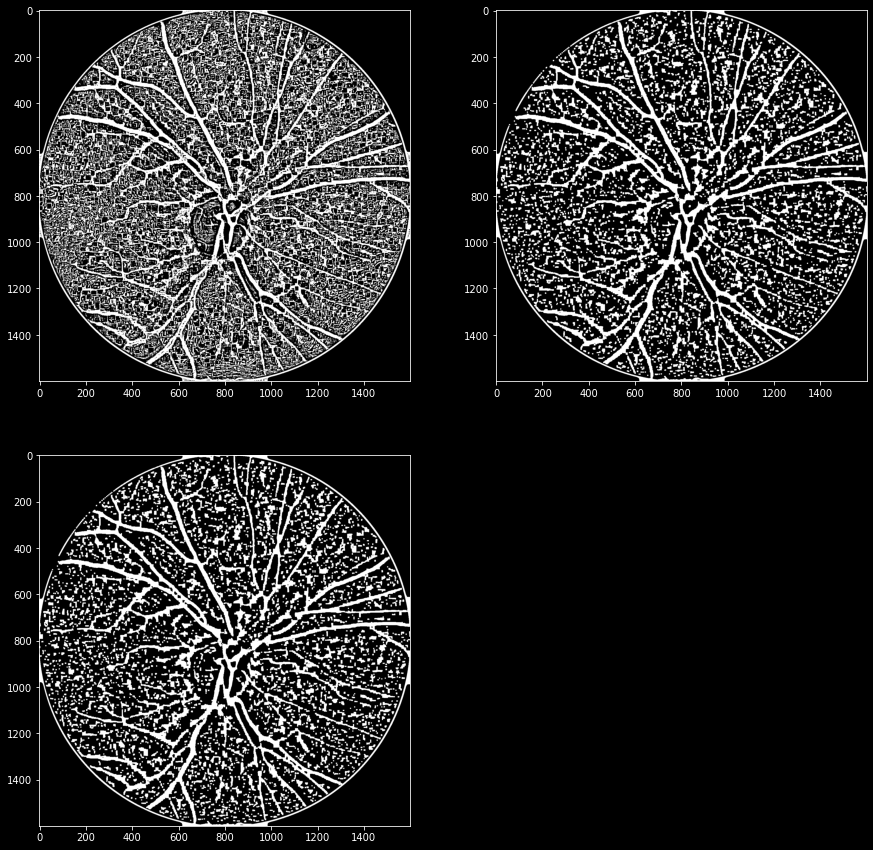

In [156]:
plt.figure(figsize=(15,15))
denoise_thresh = opening(thresh_img_denoise_eq_1, np.ones((5,5)))
opened_img = opening(thresh_img_denoise_eq_1, np.ones((5,5)))

plt.subplot(221)
plt.imshow(thresh_eq_img, cmap='gray')
plt.subplot(222)
plt.imshow(denoise_thresh, cmap='gray')
plt.subplot(223)
plt.imshow(opened_img, cmap='gray')


### Testing simple global threshold

Text(0.5, 0, 'Adaptive threshold')

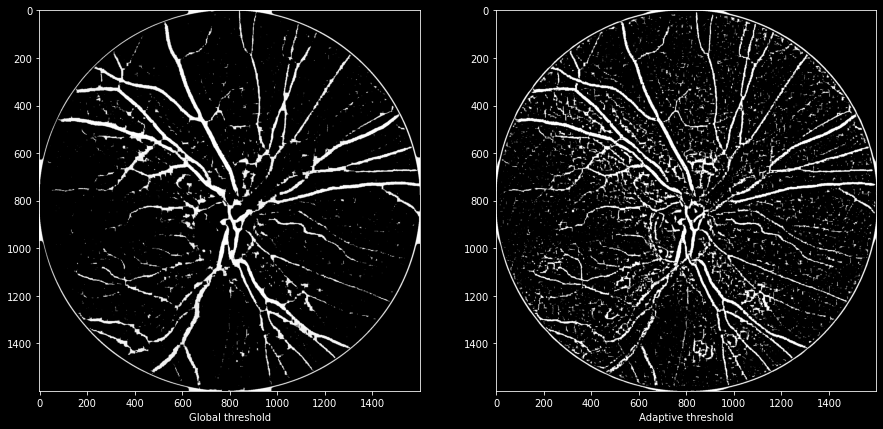

In [157]:
_, global_thresh = cv2.threshold(np.bitwise_not(diff_img_eq), 230, 255, cv2.THRESH_TOZERO)
adaptive_thresh = np.bitwise_not(cv2.adaptiveThreshold(diff_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 41, 5))
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(global_thresh, cmap="gray")
plt.xlabel('Global threshold')
plt.subplot(122)
plt.imshow(adaptive_thresh, cmap="gray")
plt.xlabel('Adaptive threshold')

Text(0.5, 0, 'Adaptive threshold after closing')

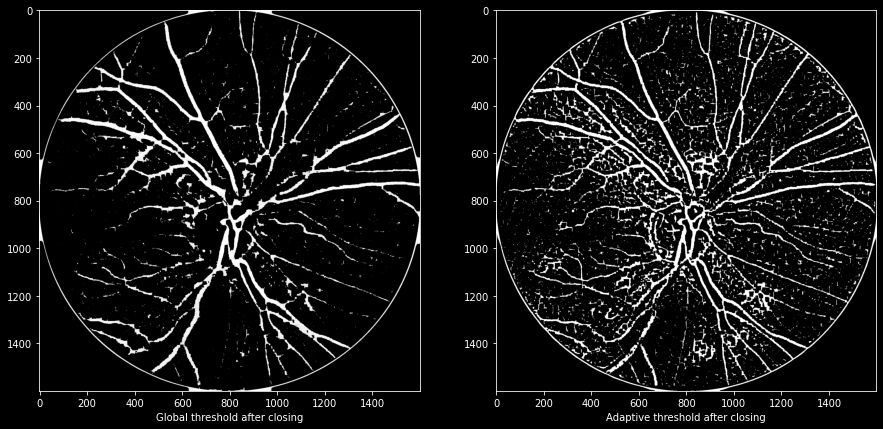

In [158]:
global_thresh = closing(global_thresh.astype(np.uint8), np.ones((3,3)))
adaptive_thresh = closing(adaptive_thresh.astype(np.uint8), np.ones((5,5)))
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(global_thresh, cmap='gray')
plt.xlabel('Global threshold after closing')
plt.subplot(122)
plt.imshow(adaptive_thresh, cmap='gray')
plt.xlabel('Adaptive threshold after closing')

In [159]:
def remove_small_areas(img, min_area):
    label_img = measure.label(img, background=0 ,connectivity=2)
    regions = measure.regionprops(label_img)

    masks = []
    bbox = []
    list_of_index = []
    for num, x in enumerate(regions):
        area = x.area
        if (area>min_area):
            masks.append(regions[num].convex_image)
            bbox.append(regions[num].bbox)   
            list_of_index.append(num)

    for box, mask in zip(bbox, masks):
        reduced_img = img[box[0]:box[2], box[1]:box[3]] * mask

    mask = np.zeros_like(label_img)
    for x in list_of_index:
        mask += (label_img==x+1).astype(int)
    reduced_img  =  img * mask

    return reduced_img


Text(0.5, 0, 'Adaptive threshold after removing small areas')

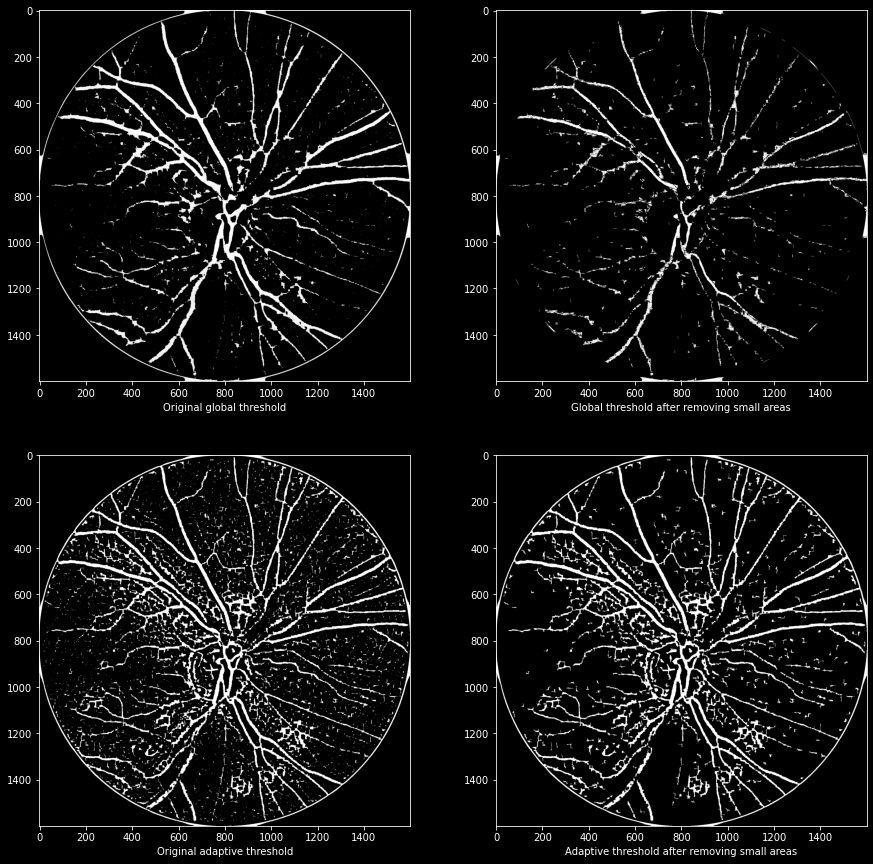

In [160]:
reduced_global = remove_small_areas(global_thresh, 10)
reduced_adaptive = remove_small_areas(adaptive_thresh, 50)
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(global_thresh, cmap="gray")
plt.xlabel('Original global threshold')
plt.subplot(222)
plt.imshow(reduced_global, cmap="gray")
plt.xlabel('Global threshold after removing small areas')

plt.subplot(223)
plt.imshow(adaptive_thresh, cmap="gray")
plt.xlabel('Original adaptive threshold')
plt.subplot(224)
plt.imshow(reduced_adaptive, cmap="gray")
plt.xlabel('Adaptive threshold after removing small areas')

Text(0.5, 0, 'Adatptive threshold skeleton')

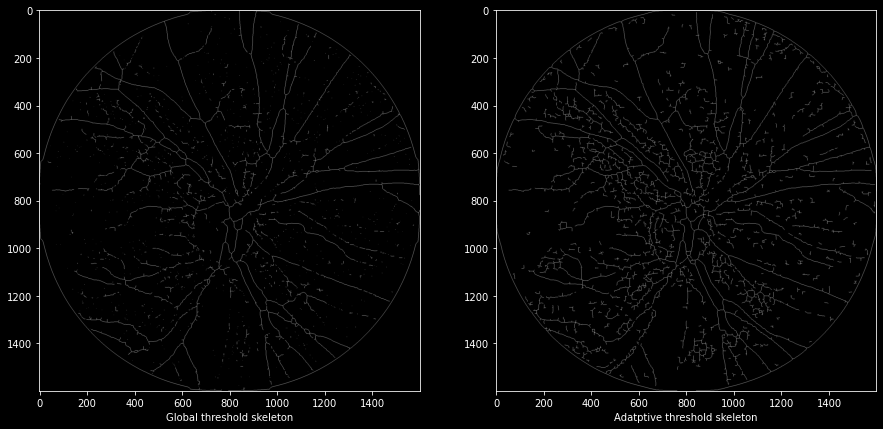

In [161]:
global_skeleton = skeletonize(global_thresh.astype(bool))
adaptive_skeleton = skeletonize(reduced_adaptive.astype(bool))
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(global_skeleton, cmap="gray")
plt.xlabel('Global threshold skeleton')
plt.subplot(122)
plt.imshow(adaptive_skeleton, cmap='gray')
plt.xlabel('Adatptive threshold skeleton')

In [162]:
def mark_potential_landmark(img):
    mask = np.ones((3,3))
    mask[1,1] = 0
    mask = mask.astype(bool)
    N,M = img.shape
    landmarks = []
    coords = np.argwhere(img == True)
    for (x,y) in coords:
      #inside circle
      if(x-1 < 0 or y-1 < 0 or x+2 > N or y+2 > M):
        continue
      sub_img = img[x-1:x+2, y-1:y+2]
      img_sum = np.sum(np.bitwise_and(sub_img, mask))
      if(img_sum == 3 or img_sum == 4):
          landmarks.append((x,y))
    return landmarks

In [171]:
land = mark_potential_landmark(adaptive_skeleton)
len(land)

4177

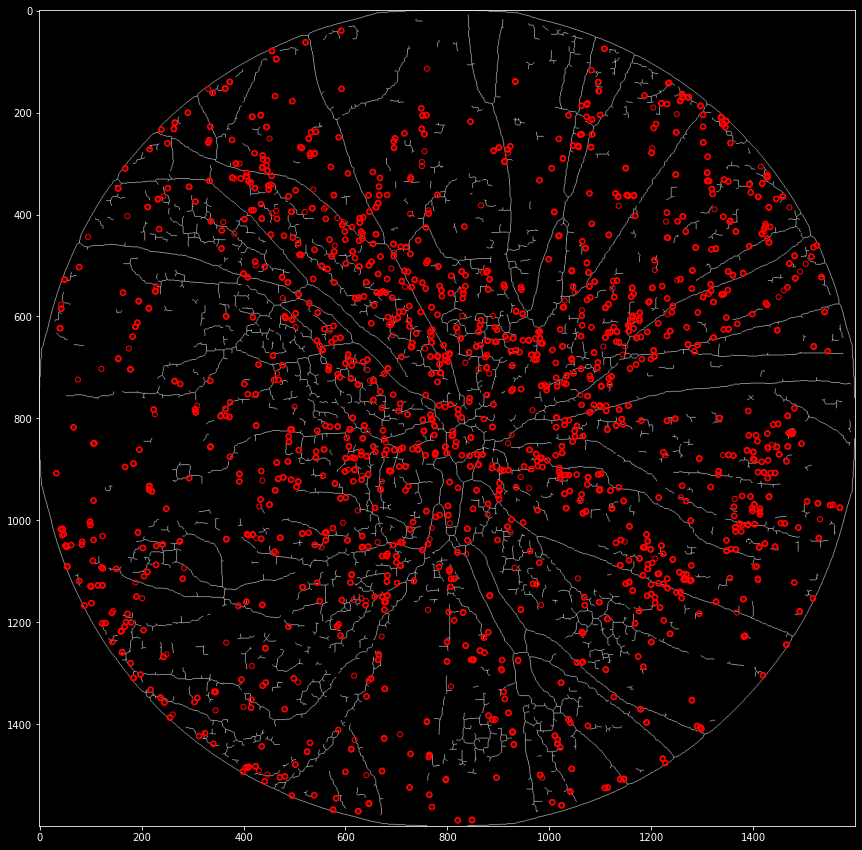

In [172]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(adaptive_skeleton, cmap='gray')
for (x, y) in land:
    rect = patches.Circle((x,y), 5, linewidth=1, edgecolor='r', facecolor='none', fill=False)
    ax.add_patch(rect)
plt.show()

In [165]:
def calculate_widths(img, landmarks):
    widths = []
    for x,y in landmarks:
        #up        
        i = x
        j = y
        vert_dist = 0
        while(j<1600 and img[i,j]!=0):
            vert_dist+=1
            j+=1
        
        #down
        i=x
        j=y
        while(j>=0 and img[i,j]!=0 ):
            vert_dist+=1
            j-=1
        
        #right
        horiz_dist = 0
        i = x
        j = y
        while(i<1600 and img[i,j]!=0):
            horiz_dist+=1
            i+=1

        #left
        i=x
        j=y
        while(i>=0 and img[i,j]!=0):
            horiz_dist+=1
            i-=1
        
        #up right
        i=x
        j=y
        p_diag_dist=0
        while(i<1600 and j<1600 and img[i,j]!=0):
            i+=1
            j+=1
            p_diag_dist+=1
        
        #down left
        i=x
        j=y
        while(i>=0 and j>=0 and img[i,j]!=0):
            i-=1
            j-=1
            p_diag_dist+=1

        #up left
        i=x
        j=y
        s_diag_dist=0
        while(i>=0 and j<1600 and img[i,j]!=0):
            i-=1
            j+=1
            s_diag_dist+=1

        #down right
        i=x
        j=y
        while(i<1600 and j>=0 and img[i,j]!=0):
            i+=1
            j-=1
            s_diag_dist+=1
        
        min = np.min([vert_dist, horiz_dist, p_diag_dist, s_diag_dist])
        widths.append([(x,y), min])
    return widths

In [173]:
widths = calculate_widths(global_thresh, land)

In [167]:
def make_circle(radius):
    d = int(2*radius+1)
    rx, ry = d/2, d/2
    x,y = np.indices((d,d))
    return ((np.abs(np.hypot(rx-x, ry-y)-radius)) < 0.5).astype(np.uint8)

In [168]:
def mark_intersections_and_intersections(widths, skeleton_img):
    bifurcations = []
    intersections = []
    for (x,y), width in widths:
        diam = 3*width
        radius = diam//2
        circle = make_circle(radius)
        if(x-radius < 0 or y-radius < 0 or x+radius+1>skeleton_img.shape[0] or y+radius+1 > skeleton_img.shape[1]):
          continue
        sub_img = skeleton_img[x-radius:x+radius+1, y-radius:y+radius+1].astype(bool)

        sum = np.sum(np.bitwise_and(sub_img, circle))
        if(sum == 3):
            bifurcations.append((x,y))
        elif(sum == 4):
            intersections.append((x,y))
    return bifurcations, intersections

In [174]:
bifurcations, intersections = mark_intersections_and_intersections(widths, global_skeleton)
print(len(bifurcations), len(intersections))

382 186


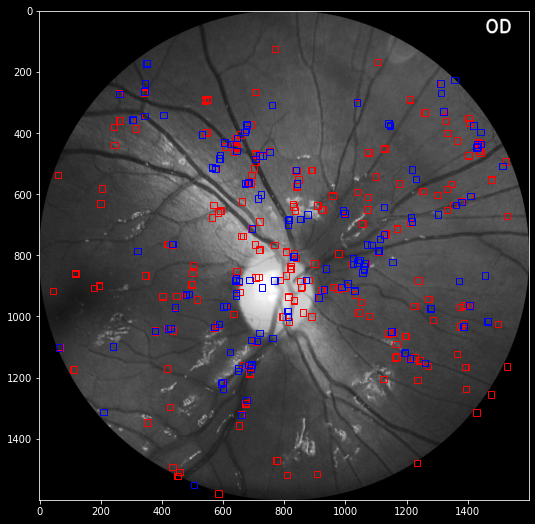

In [175]:
fig, ax = plt.subplots(figsize=(9,9))
ax.imshow(img_g, cmap='gray')
for x, y in bifurcations:
    rect = patches.Rectangle((x,y), 21,21, linewidth=1, edgecolor='r', facecolor='none', fill=False)
    ax.add_patch(rect)
for x,y in intersections:
    rect = patches.Rectangle((x,y), 21,21, linewidth=1, edgecolor='b', facecolor='none', fill=False)
    ax.add_patch(rect)
plt.show()